# VIX Modeling

In this notebook, we evaluate three different models of the VIX that we may use in our trading algorithm.

First, we import the libraries we need for our models. Some are more common (yfinance, pandas, numpy, matplotlib), while others are less so.

We import arch.arch_model, where arch is a library that allows us to model the VIX using a GARCH(1, 1) model (see [here](https://bashtage.github.io/arch/univariate/univariate_volatility_modeling.html) and [here](https://bashtage.github.io/arch/univariate/introduction.html) for documentation).

We also import the ARIMA model from the [statsmodels library](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html), as well as other functions from [tensorflow](https://keras.io/about/).

In [1]:
# Import libraries
import warnings
import datetime as dt
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU

Next, we download the necessary VIX data using YahooFinance. We will split the data into training and testing data for each of our models, beginning testing on January 1, 2022.

Quick note: setting progress to `False` hides the progress bar while the data is downloading

In [2]:
# Download VIX data
start_training = dt.date(2005, 1, 1)
end_training = dt.date(2021, 12, 31)
start_test = dt.date(2022, 1, 1)
end_test = dt.datetime.today()

# Split the data into training and testing
vix_train = yf.download('^VIX', start=start_training, end=end_training, progress=False)
vix_test = yf.download('^VIX', start=start_test, end=end_test, progress=False)

Next, we will convert our dataset from daily to weekly intervals. This decreases the daily noise of our data, and also makes it much easier to work with the ARIMA model frequency attribute.

In [3]:
# Converting our data from daily to weekly
# Open - assigned to first price of the week
# High - weekly maximum
# Low - weekly minimum
# Close - assigned to last price of the week
# Adj Close - adjusted close of the week (factors in dividends, splits, etc.)

vix_train = vix_train.resample('W').agg({'Open':'first', 'High':'max', 'Low':'min',
    'Close':'last', 'Adj Close': 'last'})

We then calculate the log returns of the VIX for our modeling, shifting by 1 to offset the first day of the dataset. The second line drops this part of the table, as it has a NaN value.

In [4]:
# Calculate log returns
vix_train['log_returns'] = np.log(vix_train['Adj Close'] / vix_train['Adj Close'].shift(1))
vix_train.dropna(inplace=True)

### ARIMA model
First, we use the ARIMA library to model the VIX returns, where we set the lag value to 1 for autoregression, have no time differencing, and set our moving averave component order to 1. This means that our model will use the previous value and error term to predict future values of the time series (the VIX).

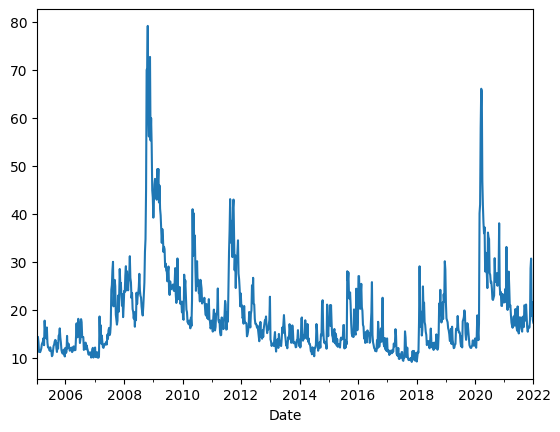

In [5]:
vix_train['Adj Close'].plot()
adjclose = vix_train['Adj Close']

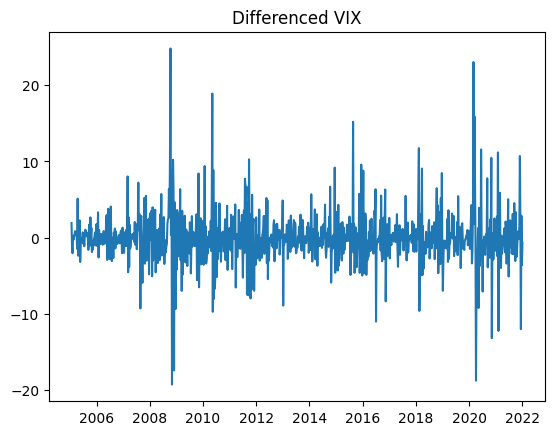

In [6]:
diff = adjclose.diff().dropna()
plt.plot(diff)
plt.title('Differenced VIX')
plt.show()

In [7]:
print(diff)

Date
2005-01-23     1.929999
2005-01-30    -1.120000
2005-02-06    -2.030000
2005-02-13     0.220000
2005-02-20    -0.250000
                ...    
2021-12-05     2.049999
2021-12-12   -11.980000
2021-12-19     2.879999
2021-12-26    -3.610001
2022-01-02    -0.629999
Freq: W-SUN, Name: Adj Close, Length: 885, dtype: float64


Date
2005-01-23     1.929999
2005-01-30    -1.120000
2005-02-06    -2.030000
2005-02-13     0.220000
2005-02-20    -0.250000
                ...    
2021-12-05     2.049999
2021-12-12   -11.980000
2021-12-19     2.879999
2021-12-26    -3.610001
2022-01-02    -0.629999
Freq: W-SUN, Name: Adj Close, Length: 885, dtype: float64


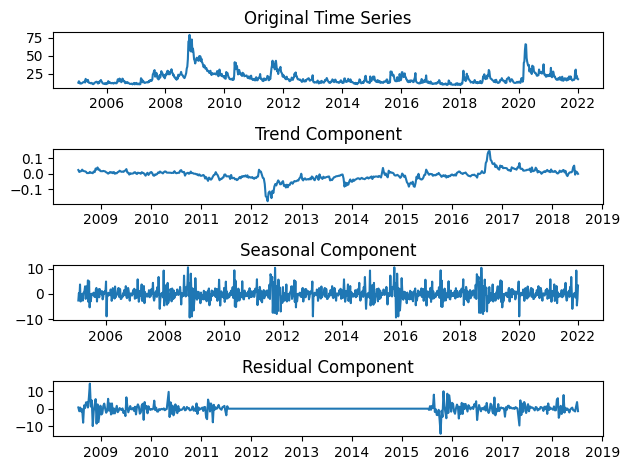

In [8]:
diff.sort_index(inplace=True)
#diff['date'] = pd.to_datetime(diff['date'])
print(diff)
# Decompose time series
decomposition = seasonal_decompose(diff, model='additive', period = 365)

# Plot original time series
plt.subplot(411)
plt.plot(adjclose)
plt.title('Original Time Series')

# Plot trend component
plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend Component')

# Plot seasonal component
plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Seasonal Component')

# Plot residual component
plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residual Component')

# Show plots
plt.tight_layout()
plt.show()

{(0, 0, 0): 4745.349859097289, (0, 0, 1): 4730.795698852894, (0, 0, 2): 4732.790030281672, (0, 0, 3): 4730.4200433396145, (0, 1, 0): 5464.695771690191, (0, 1, 1): 4747.791329915261, (0, 1, 2): 4733.537662689287, (0, 1, 3): 4735.522213294127, (0, 2, 0): 6469.109714355758, (0, 2, 1): 5468.300518279737, (0, 2, 2): 4761.2471640270605, (0, 2, 3): 4747.901688084381, (1, 0, 0): 4730.718434047831, (1, 0, 1): 4732.60932320708, (1, 0, 2): 4731.585319734615, (1, 0, 3): 4712.185423972462, (1, 1, 0): 5120.9168284763, (1, 1, 1): 4733.420544769852, (1, 1, 2): 4735.188629921484, (1, 1, 3): 4734.277972164704, (1, 2, 0): 5837.799131319078, (1, 2, 1): 5125.812024136119, (1, 2, 2): 4747.552178938585, (1, 2, 3): 4764.2730224763545, (2, 0, 0): 4732.715112312254, (2, 0, 1): 4711.575749797588, (2, 0, 2): 4709.187816226076, (2, 0, 3): 4711.081123341464, (2, 1, 0): 5027.554183879234, (2, 1, 1): 4735.411143945887, (2, 1, 2): 4734.726755337355, (2, 1, 3): 4738.151424166521, (2, 2, 0): 5599.1655936136, (2, 2, 1): 

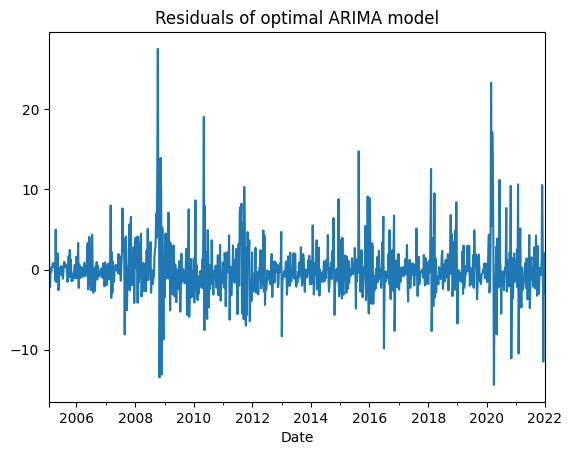

In [9]:
# ARIMA model
from itertools import product

p = range(0, 4)
d = range(0, 3)
q = range(0, 4)
pdq = list(product(p, d, q))

# Suppress different warnings (appear because we cycle through all permutations)
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")
warnings.filterwarnings("ignore", message='Non-stationary starting autoregressive parameters')
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to ")

# Fit and evaluate each ARIMA model using AIC
models = {}
for para in pdq:
    try:
        model = ARIMA(diff, order=para)
        results = model.fit()
        models[para] = results.aic
    except:
        continue

print(models)

# Select the best ARIMA model based on the lowest AIC value
best_para, best_aic = min(models.items(), key=lambda x: x[1])
best_model = ARIMA(diff, order=best_para)
arima_fit = best_model.fit()

# Print the summary of the best ARIMA model
print(arima_fit.summary())

# Plot the residuals of the best ARIMA model
residuals = pd.DataFrame(arima_fit.resid)
residuals.plot()
plt.title('Residuals of optimal ARIMA model')
plt.legend().remove()
plt.show()

### GARCH model
Using the arch_model from our arch library, we model the residuals of the ARIMA model, setting error and time dependency terms to order of magnitude of 1. This creates the GARCH(1, 1) model that is widely used in modeling, notable for its simplicity and ease of implementation. We then use the arch_garch_model.fit() method to fit our model. This produces an output table that is printed at the end.

In [ ]:
# GARCH model
garch_model = arch_model(residuals, vol='Garch', p=1, q=1, rescale=False)
garch_fit = garch_model.fit(update_freq=5)

### GRU RNN Model

Finally, we prepare our data and train a Gated Recurrent Unit (GRU) based Recurrent Neural Network (RNN) model for time series prediction on our VIX log returns. The model is designed with a single-layer GRU containing 4 units, and takes into account the previous value of the time series for making predictions.

For our neural net, we define a GRU RNN model with 4 unit, and compile using mean squared error as the loss function and the Adam optimizer. We then use 70 epochs for our training and a batch size of 1, though this can be adjusted depending on available compute.

This GRU RNN model serves as a neural network-based approach to predict future values of the VIX log returns, leveraging the temporal relationships within the time series data.

In [ ]:
# Data preparation for GRU RNN model
train_data = vix_train['log_returns'].values.reshape(-1, 1)

# Scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)

# Prepare data for time series model
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        x = dataset[i:(i + look_back), 0]
        y = dataset[i + look_back, 0]
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

look_back = 1
X_train, y_train = create_dataset(train_data_scaled, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

# GRU RNN model
# Lowered the number of epochs so my computer didn't die
gru_rnn_model = Sequential()
gru_rnn_model.add(GRU(4, input_shape=(1, look_back)))
gru_rnn_model.add(Dense(1))
gru_rnn_model.compile(loss='mean_squared_error', optimizer='adam')
# epochs = 70 so that my laptop doesn't end itself
gru_rnn_model.fit(X_train, y_train, epochs=70, batch_size=1, verbose=0)

### Print Model Summaries
We them print a summary of each of our models, which gives us an indication of their parameters, as well as how well they perform.

In [ ]:
# Model summaries
print("ARCH/GARCH Model Summary:")
print(garch_fit.summary())
print("\nARIMA Model Summary:")
print(arima_fit.summary())
# print("\nGRU RNN Model Summary:")
# gru_rnn_model.summary()

### Testing time!!!!!!

Here is where we will compare each model with testing data

In [ ]:
# Convert testing data from daily to weekly intervals
# Converting our data from daily to weekly
# Open - assigned to first price of the week
# High - weekly maximum
# Low - weekly minimum
# Close - assigned to last price of the week
# Adj Close - adjusted close of the week (factors in dividends, splits, etc.)

vix_test = vix_test.resample('W').agg({'Open':'first', 'High':'max', 'Low':'min',
    'Close':'last', 'Adj Close': 'last'})

# Select only 'Adj Close' (for chart comparisons)
vix_test.drop(columns=['Open', 'High', 'Low', 'Close'])

C:\Users\pjbro\AppData\Local\Temp\ipykernel_13556\3999781407.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series()


predicted=16.650293, expected=16.600000
predicted=16.480293, expected=16.910000
predicted=16.790292, expected=19.730000
predicted=19.610292, expected=19.610001
predicted=19.490293, expected=18.760000
predicted=18.640292, expected=19.400000
predicted=19.280292, expected=18.410000
predicted=18.290292, expected=17.620001
predicted=17.500293, expected=20.309999
predicted=20.190292, expected=19.190001
predicted=19.070293, expected=22.790001
predicted=22.670293, expected=23.850000
predicted=23.730293, expected=25.590000
predicted=25.470292, expected=28.850000
predicted=28.730293, expected=29.900000
predicted=29.780292, expected=31.160000
predicted=31.040292, expected=31.959999
predicted=31.840291, expected=30.490000
predicted=30.370292, expected=27.660000
predicted=27.540292, expected=24.830000
predicted=24.710292, expected=21.959999
predicted=21.840291, expected=22.090000
predicted=21.970292, expected=24.350000
predicted=24.230293, expected=23.219999
predicted=23.100292, expected=22.860001


predicted=27.270292, expected=25.750000
predicted=25.630292, expected=25.879999
predicted=25.760291, expected=25.809999
predicted=25.690292, expected=25.860001
predicted=25.740293, expected=25.299999
predicted=25.180291, expected=24.549999
predicted=24.430291, expected=24.350000
predicted=24.230293, expected=25.540001
predicted=25.420293, expected=26.090000
predicted=25.970292, expected=23.530001
predicted=23.410293, expected=22.520000
predicted=22.400293, expected=23.730000
predicted=23.610292, expected=24.540001
predicted=24.420293, expected=24.110001
predicted=23.990293, expected=23.930000
predicted=23.810293, expected=23.120001
predicted=23.000293, expected=22.360001
predicted=22.240293, expected=21.290001
predicted=21.170293, expected=20.350000
predicted=20.230293, expected=20.500000
predicted=20.380292, expected=22.209999
predicted=22.090291, expected=21.889999
predicted=21.770292, expected=20.580000
predicted=20.460292, expected=19.840000
predicted=19.720292, expected=19.059999


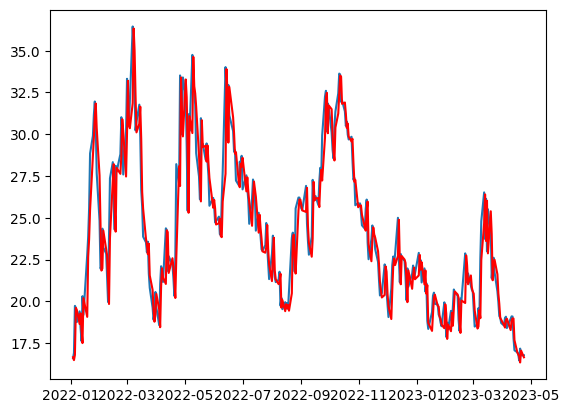

In [10]:
history = [x for x in vix_train]
predictions = pd.Series()

# walk-forward validation
for t in range(len(vix_test)):
    output = arima_fit.forecast()
    yhat = output[0]
    predictions.loc[t] = yhat + vix_test['Adj Close'][t-1]
    obs = vix_test['Adj Close'][t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (predictions[t], obs))
    
predictions.index = vix_test.index
# evaluate forecasts
rmse = (mean_squared_error(vix_test['Adj Close'], predictions))**0.5
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(vix_test['Adj Close'])
plt.plot(predictions, color='red')
plt.show()

In [ ]:
# Define the forecasting horizon (e.g., 30 trading days)
forecast_horizon = 30

# Generate ARIMA forecasts
arima_forecast = arima_fit.get_forecast(steps=forecast_horizon)

arima_mean_forecast = arima_forecast.predicted_mean
# print(arima_mean_forecast)
# print(vix_test['Adj Close'])

forecasted_vix = arima_mean_forecast 

forecast_error = vix_test['Adj Close'] - arima_mean_forecast
forecast_error = forecast_error.dropna()

mean_absolute_error = np.mean(np.abs(forecast_error))
m_s_e = np.mean(forecast_error ** 2)
root_mean_squared_error = np.sqrt(mean_squared_error)

print(f"Mean Absolute Error: {mean_absolute_error}")
print(f"Mean Squared Error: {mean_squared_error}")
print(f"Root Mean Squared Error: {root_mean_squared_error}")

# Visualize the forecast and test data
plt.figure(figsize=(10, 6))
plt.plot(vix_test.index, vix_test, label='Actual VIX', color='blue')
plt.plot(forecasted_vix.index, forecasted_vix, label='Forecasted VIX', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('VIX')
plt.title('VIX Actual vs Forecast')
plt.legend()
plt.show()

In [ ]:
# ARIMA & GARCH combined forecasting

# Use the ARIMA model to predict mu
predicted_mu = arima_fit.predict(n_periods=1)[0]

# Use the GARCH model to predict residual
garch_forecast = garch_fit.forecast(horizon=1)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]

# Combining models for prediction
ag_prediction = predicted_mu + predicted_et

In [12]:
# GARCH Modeling
predictions = pd.DataFrame(columns=['Date','prediction'])
history = vix_train

warnings.filterwarnings("ignore")

for t in range(len(vix_test)):
    print(t)
    garch_model = arch_model(history["Adj Close"], vol='Garch', p=1, q=1, rescale=False)
    garch_fit = garch_model.fit(update_freq=5)
    
    
    output=garch_fit.forecast()
    pred=output.variance.iloc[-1].values[0]
#     print(vix_test['Adj Close'][t-1])
#     print(pred)
    obs = vix_test['Adj Close'][t]
    print('predicted=%f, expected=%f' % (pred, obs))
    to_insert = {'Date': vix_test.reset_index()['Date'].iloc[t], 'prediction' :pred}
    predictions = predictions.append(to_insert, ignore_index=True)
    history = history.append(vix_test.iloc[t])
    

# evaluate forecasts
# rmse = (mean_squared_error(vix_test['Adj Close'], predictions))**0.5
# print('Test RMSE: %.3f' % rmse)
   

forecasts = garch_fit.forecast(horizon=5, reindex=False)
print(forecasts.variance.dropna()['h.1'])
forecasted_volatility = forecasts.residual_variance.dropna()

# Plot the predicted volatility against the actual volatility (magnitude of returns)
plt.figure()
# plt.plot(vix_test.abs(), label="Actual Volatility", color= "blue")
# plt.plot(forecasts.variance, label="Predicted Volatility", color='red', ms=5)
p.variance.dropna()['h.1'].plot(ms = 6)
plt.legend()
plt.title("Volatility Prediction by GARCH(1, 1) Model")
plt.show()

0
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2908.7468172918852
Iteration:     10,   Func. Count:     59,   Neg. LLF: 2672.121491427857
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2672.0118619780133
            Iterations: 14
            Function evaluations: 78
            Gradient evaluations: 14
predicted=15.147146, expected=16.600000
1
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2910.2787069539945
Iteration:     10,   Func. Count:     59,   Neg. LLF: 2674.6021352576827
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2674.4999334013137
            Iterations: 14
            Function evaluations: 78
            Gradient evaluations: 14
predicted=10.882807, expected=16.910000
2
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2903.801454102786
Iteration:     10,   Func. Count:     59,   Neg. LLF: 2677.085983993996
Optimization terminated successfully    (Exit mode 0)
     

Iteration:     10,   Func. Count:     60,   Neg. LLF: 2749.5814560540257
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2749.476414527222
            Iterations: 14
            Function evaluations: 79
            Gradient evaluations: 14
predicted=67.605385, expected=24.350000
23
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2868.877161333805
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2753.3308318026093
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2753.271891052423
            Iterations: 14
            Function evaluations: 79
            Gradient evaluations: 14
predicted=108.538704, expected=23.219999
24
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2854.9901969348557
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2756.9670420664443
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2756.9133251974254
            Iterations

Iteration:      5,   Func. Count:     32,   Neg. LLF: 2860.9322164886607
Iteration:     10,   Func. Count:     57,   Neg. LLF: 2828.940139265301
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2828.8867711904686
            Iterations: 14
            Function evaluations: 76
            Gradient evaluations: 14
predicted=269.716035, expected=31.980000
43
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2865.3787474229644
Iteration:     10,   Func. Count:     57,   Neg. LLF: 2833.244292075698
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2833.192136859735
            Iterations: 14
            Function evaluations: 76
            Gradient evaluations: 14
predicted=320.749277, expected=36.450001
44
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2870.0872851351664
Iteration:     10,   Func. Count:     57,   Neg. LLF: 2837.8231994404005
Optimization terminated successfully    (Exit mode 0)
   

Iteration:      5,   Func. Count:     33,   Neg. LLF: 2947.2891984325042
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2905.5197550950456
Iteration:     15,   Func. Count:     84,   Neg. LLF: 2905.251728235945
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2905.251727819616
            Iterations: 15
            Function evaluations: 84
            Gradient evaluations: 15
predicted=44.393491, expected=19.629999
63
Iteration:      5,   Func. Count:     33,   Neg. LLF: 2949.4403308980345
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2908.760392706992
Iteration:     15,   Func. Count:     85,   Neg. LLF: 2908.391426874431
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2908.391426874431
            Iterations: 15
            Function evaluations: 85
            Gradient evaluations: 15
predicted=33.490525, expected=18.570000
64
Iteration:      5,   Func. Count:     33,   Neg. LLF: 2952.20

Iteration:     10,   Func. Count:     60,   Neg. LLF: 2975.8383822264805
Iteration:     15,   Func. Count:     84,   Neg. LLF: 2974.8826758182295
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2974.8826754372603
            Iterations: 15
            Function evaluations: 84
            Gradient evaluations: 15
predicted=250.063682, expected=33.400002
82
Iteration:      5,   Func. Count:     33,   Neg. LLF: 3009.5663996967405
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2980.2821047977245
Iteration:     15,   Func. Count:     84,   Neg. LLF: 2979.29136038236
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2979.2913600056095
            Iterations: 15
            Function evaluations: 84
            Gradient evaluations: 15
predicted=368.436645, expected=32.340000
83
Iteration:      5,   Func. Count:     33,   Neg. LLF: 3013.8698884477844
Iteration:     10,   Func. Count:     60,   Neg. LLF: 29

Iteration:     10,   Func. Count:     60,   Neg. LLF: 3055.7638978149525
Iteration:     15,   Func. Count:     84,   Neg. LLF: 3054.723957117916
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3054.7239567586166
            Iterations: 15
            Function evaluations: 84
            Gradient evaluations: 15
predicted=200.889258, expected=27.500000
101
Iteration:      5,   Func. Count:     33,   Neg. LLF: 3086.706409343412
Iteration:     10,   Func. Count:     60,   Neg. LLF: 3059.7801606327675
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3058.7242793467212
            Iterations: 14
            Function evaluations: 79
            Gradient evaluations: 14
predicted=177.216999, expected=25.719999
102
Iteration:      5,   Func. Count:     33,   Neg. LLF: 3090.3954363780576
Iteration:     10,   Func. Count:     60,   Neg. LLF: 3063.6675477254335
Iteration:     15,   Func. Count:     84,   Neg. LLF: 

Iteration:     10,   Func. Count:     60,   Neg. LLF: 3132.1986780659804
Iteration:     15,   Func. Count:     84,   Neg. LLF: 3131.068790533889
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3131.0687901868905
            Iterations: 15
            Function evaluations: 84
            Gradient evaluations: 15
predicted=218.967659, expected=27.230000
120
Iteration:      5,   Func. Count:     33,   Neg. LLF: 3161.6589775695606
Iteration:     10,   Func. Count:     60,   Neg. LLF: 3136.238548456965
Iteration:     15,   Func. Count:     84,   Neg. LLF: 3135.057682941452
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3135.057682593338
            Iterations: 15
            Function evaluations: 84
            Gradient evaluations: 15
predicted=168.958741, expected=26.950001
121
Iteration:      5,   Func. Count:     33,   Neg. LLF: 3165.629096719746
Iteration:     10,   Func. Count:     60,   Neg. LLF: 314

Iteration:     15,   Func. Count:     86,   Neg. LLF: 3204.9602498664462
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3204.9602483122717
            Iterations: 17
            Function evaluations: 95
            Gradient evaluations: 17
predicted=79.483744, expected=23.030001
139
Iteration:      5,   Func. Count:     33,   Neg. LLF: 3237.9232652397095
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3210.956977041557
Iteration:     15,   Func. Count:     86,   Neg. LLF: 3208.52704511815
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3208.527039897458
            Iterations: 17
            Function evaluations: 95
            Gradient evaluations: 17
predicted=78.039723, expected=23.360001
140
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3243.5654397450335
Iteration:     10,   Func. Count:     60,   Neg. LLF: 3214.786096820998
Iteration:     15,   Func. Count:     85,   Neg. LLF: 3212.

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3266.050271950413
            Iterations: 18
            Function evaluations: 99
            Gradient evaluations: 18
predicted=31.249761, expected=19.900000
157
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3303.497265341329
Iteration:     10,   Func. Count:     60,   Neg. LLF: 3271.922485533125
Iteration:     15,   Func. Count:     85,   Neg. LLF: 3269.1428878483493
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3269.14286676944
            Iterations: 17
            Function evaluations: 94
            Gradient evaluations: 17
predicted=33.369780, expected=19.559999
158
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3306.9244008140495
Iteration:     10,   Func. Count:     60,   Neg. LLF: 3275.0224168069467
Iteration:     15,   Func. Count:     85,   Neg. LLF: 3272.185781924491
Optimization terminated successfully    (Exit mode 0)
      

Iteration:     15,   Func. Count:     86,   Neg. LLF: 3335.763503570355
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3335.6060193548383
            Iterations: 19
            Function evaluations: 105
            Gradient evaluations: 19
predicted=164.099845, expected=26.160000
176
Iteration:      5,   Func. Count:     33,   Neg. LLF: 3428.0125300286145
Iteration:     10,   Func. Count:     60,   Neg. LLF: 3343.4193972919343
Iteration:     15,   Func. Count:     85,   Neg. LLF: 3339.4858755695213
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3339.4782222266585
            Iterations: 18
            Function evaluations: 99
            Gradient evaluations: 18
predicted=137.265314, expected=26.270000
177
Iteration:      5,   Func. Count:     33,   Neg. LLF: 3423.444908736489
Iteration:     10,   Func. Count:     60,   Neg. LLF: 3348.481200203429
Iteration:     15,   Func. Count:     85,   Neg. LLF: 

Iteration:     15,   Func. Count:     85,   Neg. LLF: 3413.4914465678216
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3413.4914427146796
            Iterations: 17
            Function evaluations: 94
            Gradient evaluations: 17
predicted=319.432338, expected=33.630001
195
Iteration:      5,   Func. Count:     33,   Neg. LLF: 3440.2592545693124
Iteration:     10,   Func. Count:     60,   Neg. LLF: 3418.831401345028
Iteration:     15,   Func. Count:     85,   Neg. LLF: 3417.8542592953436
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3417.854258397513
            Iterations: 16
            Function evaluations: 90
            Gradient evaluations: 16
predicted=362.559414, expected=33.570000
196
Iteration:      5,   Func. Count:     33,   Neg. LLF: 3444.1715309734022
Iteration:     10,   Func. Count:     60,   Neg. LLF: 3423.0838343530795
Iteration:     15,   Func. Count:     85,   Neg. LLF: 

Iteration:      5,   Func. Count:     34,   Neg. LLF: 3557.577851247621
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3494.238551280166
Iteration:     15,   Func. Count:     86,   Neg. LLF: 3490.5407252170316
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3490.5233044309566
            Iterations: 19
            Function evaluations: 105
            Gradient evaluations: 19
predicted=100.531679, expected=24.350000
214
Iteration:      5,   Func. Count:     34,   Neg. LLF: 3561.5916679720535
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3497.8632224753705
Iteration:     15,   Func. Count:     86,   Neg. LLF: 3494.2025280278585
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3494.2015556231827
            Iterations: 18
            Function evaluations: 100
            Gradient evaluations: 18
predicted=96.487628, expected=25.540001
215
Iteration:      5,   Func. Count:     35,   Neg. LLF:

Iteration:     15,   Func. Count:     87,   Neg. LLF: 3550.216671101158
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3550.194731756172
            Iterations: 19
            Function evaluations: 106
            Gradient evaluations: 19
predicted=36.909254, expected=19.840000
231
Iteration:      5,   Func. Count:     35,   Neg. LLF: 3631.3394301589096
Iteration:     10,   Func. Count:     62,   Neg. LLF: 3555.435010796091
Iteration:     15,   Func. Count:     87,   Neg. LLF: 3553.319718813318
Iteration:     20,   Func. Count:    111,   Neg. LLF: 3553.2416623637537
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3553.24166221546
            Iterations: 20
            Function evaluations: 111
            Gradient evaluations: 20
predicted=29.091724, expected=19.059999
232
Iteration:      5,   Func. Count:     35,   Neg. LLF: 3630.4402039163806
Iteration:     10,   Func. Count:     62,   Neg. LLF: 3558

predicted=23.293086, expected=21.969999
246
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3620.9789235693997
Iteration:     10,   Func. Count:     58,   Neg. LLF: 3604.392435212428
Iteration:     15,   Func. Count:     83,   Neg. LLF: 3603.7335706462854
Iteration:     20,   Func. Count:    107,   Neg. LLF: 3603.7303672989074
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3603.7303672989924
            Iterations: 20
            Function evaluations: 107
            Gradient evaluations: 20
predicted=35.057970, expected=20.870001
247
Iteration:      5,   Func. Count:     33,   Neg. LLF: 3639.1345341786846
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3606.8275397115895
Iteration:     15,   Func. Count:     84,   Neg. LLF: 3606.74428198497
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3606.7418006547273
            Iterations: 19
            Function evaluations: 103
            Gradien

Iteration:      5,   Func. Count:     34,   Neg. LLF: 3825.8569375283437
Iteration:     10,   Func. Count:     60,   Neg. LLF: 3653.9610049293824
Iteration:     15,   Func. Count:     85,   Neg. LLF: 3653.3613644623774
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3653.3613644623774
            Iterations: 16
            Function evaluations: 89
            Gradient evaluations: 16
predicted=17.950282, expected=19.850000
264
Iteration:      5,   Func. Count:     34,   Neg. LLF: 3839.2236996460256
Iteration:     10,   Func. Count:     60,   Neg. LLF: 3656.392647473276
Iteration:     15,   Func. Count:     84,   Neg. LLF: 3655.9449419664084
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3655.9449419661923
            Iterations: 15
            Function evaluations: 84
            Gradient evaluations: 15
predicted=15.122974, expected=19.809999
265
Iteration:      5,   Func. Count:     34,   Neg. LLF: 3

Iteration:     10,   Func. Count:     58,   Neg. LLF: 3695.3675967925083
Iteration:     15,   Func. Count:     83,   Neg. LLF: 3694.885197918663
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3694.885143085633
            Iterations: 18
            Function evaluations: 97
            Gradient evaluations: 18
predicted=9.247653, expected=18.230000
282
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3737.5259786299625
Iteration:     10,   Func. Count:     58,   Neg. LLF: 3697.315065784185
Iteration:     15,   Func. Count:     83,   Neg. LLF: 3696.9207511659747
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3696.9207511659747
            Iterations: 16
            Function evaluations: 87
            Gradient evaluations: 16
predicted=7.693885, expected=20.170000
283
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3744.44436410143
Iteration:     10,   Func. Count:     58,   Neg. LLF: 3699.60

Iteration:      5,   Func. Count:     33,   Neg. LLF: 3818.640615927403
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3740.919456334619
Iteration:     15,   Func. Count:     84,   Neg. LLF: 3740.890498386866
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3740.890497643345
            Iterations: 16
            Function evaluations: 89
            Gradient evaluations: 16
predicted=59.053499, expected=23.730000
300
Iteration:      5,   Func. Count:     33,   Neg. LLF: 3816.780151596564
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3744.112674437311
Iteration:     15,   Func. Count:     84,   Neg. LLF: 3744.0856058292147
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3744.0856058292147
            Iterations: 16
            Function evaluations: 88
            Gradient evaluations: 16
predicted=37.642726, expected=26.139999
301
Iteration:      5,   Func. Count:     33,   Neg. LLF: 3815.8

predicted=5.454716, expected=18.400000
317
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3809.9413119966616
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3785.858562562345
Iteration:     15,   Func. Count:     83,   Neg. LLF: 3785.8040615269733
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3785.804061526815
            Iterations: 15
            Function evaluations: 83
            Gradient evaluations: 15
predicted=5.416011, expected=18.969999
318
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3812.91498315436
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3787.631528114998
Iteration:     15,   Func. Count:     83,   Neg. LLF: 3787.5670813437555
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3787.567081343594
            Iterations: 15
            Function evaluations: 83
            Gradient evaluations: 15
predicted=5.263720, expected=19.100000
319
Iteration:      5, 

AttributeError: 'range' object has no attribute 'variance'

<Figure size 640x480 with 0 Axes>

In [ ]:
predictions.index = predictions["Date"]
predictions = predictions['prediction']

Text(0.5, 1.0, 'Volatility Prediction by GARCH(1, 1) Model')

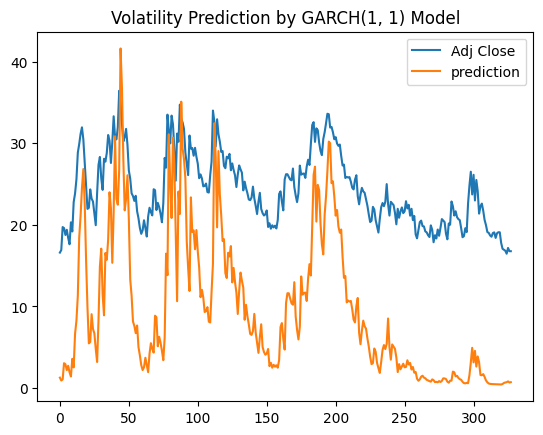

In [23]:
m= vix_test.merge(predictions, how='inner', on='Date' )

m['prediction'] = m['prediction']/12
m[['Adj Close', 'prediction']].plot()
plt.title("Volatility Prediction by GARCH(1, 1) Model")


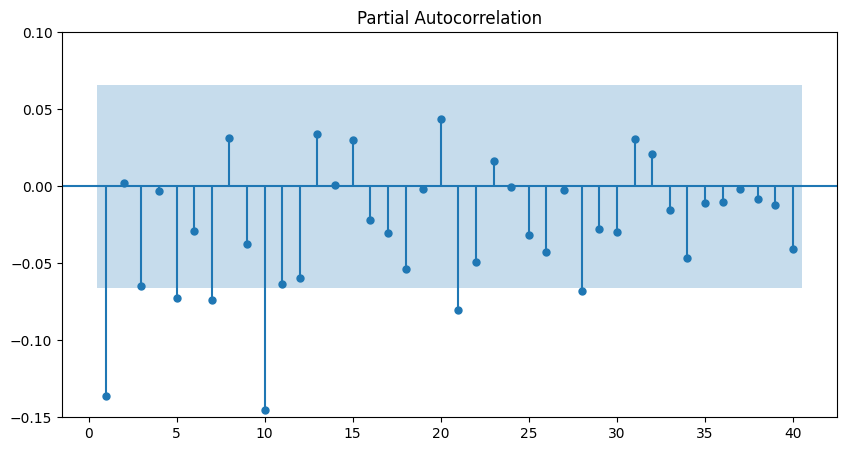

In [41]:
import statsmodels.graphics.tsaplots as sgt

# Setting the figure size
plt.rcParams["figure.figsize"] = 10, 5

# PCF Plot for Returns
fig, ax = plt.subplots()
sgt.plot_pacf(diff[1:], zero = False, lags = 40, ax=ax)

ax.set_ylim(-0.15, 0.1)

# Displaying the plot
plt.show()

In [ ]:
m_scaled

### Example output from first run